# Airport carbon intensity comparison

In [1]:
import numpy as np
from scipy.optimize import curve_fit, minimize
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

In [4]:
flights = pd.read_csv("../data/by_route_airline.csv")
flights

,departure,arrival,arrival_longitude,arrival_latitude,departure_longitude,departure_latitude,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,average_load,co2,gco2_pax_km
0,SGN,HAN,105.806999,21.221201,106.652000,10.818800,Vietnam Airlines,5,1261.547796,1.154569e+07,1.063049e+07,9152,1.993998e+06,2447017,0.814869,191365.676340,76.944016
1,HAN,SGN,106.652000,10.818800,105.806999,21.221201,Vietnam Airlines,5,1261.547796,1.092879e+07,1.006249e+07,8663,1.966054e+06,2412725,0.814869,195266.817616,79.051205
2,CJU,GMP,126.791000,37.558300,126.492546,33.512058,Asiana Airlines,5,501.253150,5.223058e+06,4.702058e+06,10420,1.782774e+06,2123733,0.839453,100145.929946,110.904076
3,GMP,CJU,126.492546,33.512058,126.791000,37.558300,Asiana Airlines,5,501.253150,5.105765e+06,4.596465e+06,10186,1.719632e+06,2048514,0.839453,96146.969851,110.549887
4,FUK,HND,139.779999,35.552299,130.451004,33.585899,All Nippon Airways,9,982.357327,8.414873e+06,7.558273e+06,8566,1.708145e+06,2438270,0.700556,161111.234068,98.852367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81839,BOO,OSL,11.100400,60.193901,14.365300,67.269203,Wideroe's Flyveselskap,1,903.632067,9.036321e+02,8.036321e+02,1,2.521278e+01,39,0.646481,3.184374,139.769276
81840,DRW,TCA,134.182999,-19.634399,130.881851,-12.414970,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626
81841,TCA,DRW,130.881851,-12.414970,134.182999,-19.634399,Airnorth Regional,1,977.769135,9.777691e+02,8.777691e+02,1,2.355192e+01,30,0.785064,3.052329,132.546626
81842,TJN,PPT,-149.606995,-17.553699,-142.266464,-15.857434,Air Tahiti,1,905.066029,9.050660e+02,8.050660e+02,1,2.111117e+01,30,0.703706,2.493229,130.487717


# Sort by airport

Get list of all airports in dataset

In [54]:
airports_departure = set(flights["departure"].values)
airports_arrival = set(flights["arrival"].values)
airports = np.array(list(airports_departure | airports_arrival))
airports

array(['LRD', 'VAI', 'ECN', ..., 'ABT', 'MBS', 'AWA'],
      shape=(3218,), dtype='<U3')

Total carbon per airport (=1/2 every flight connection)

In [55]:
departure = np.array(flights['departure'])
arrival = np.array(flights['arrival'])

carbon = np.array([sum(flights[departure == airport]['co2'])/2 +
          sum(flights[arrival == airport]['co2'])/2 for airport in airports])

Sort airports by carbon emissions, low to high

In [56]:
order = np.argsort(carbon)      # order that sorts by total carbon per airport
carbon = carbon[order]          # sort carbon by that
airports = airports[order]      # sort airports by that

Array of carbon intensities per airport

In [118]:
intensity = [np.array(list(flights[departure == airport]['gco2_pax_km']) + 
                      list(flights[arrival == airport]['gco2_pax_km'])) for airport in airports]

Carbon-weighted carbon intensity mean and standard deviation/variance

In [79]:
mean_intensity = np.zeros(len(airports))
var_intensity = np.zeros(len(airports))

for i in range(len(airports)):
    d = departure == airports[i]
    a = arrival == airports[i]

    co2_departure = np.array(flights[d]['co2'])
    co2_arrival = np.array(flights[a]['co2'])

    sum_co2_departure = np.sum(co2_departure)
    sum_co2_arrival = np.sum(co2_arrival)

    departure_intensity = np.array(flights[d]['gco2_pax_km'])
    arrival_intensity = np.array(flights[a]['gco2_pax_km'])

    mean_intensity[i] = (np.sum(departure_intensity * co2_departure) +
                         np.sum(arrival_intensity * co2_arrival)) / (sum_co2_departure + sum_co2_arrival)
    
    var_intensity[i] = (np.sum(co2_departure*(departure_intensity - mean_intensity[i])**2) +
                        np.sum(co2_arrival*(arrival_intensity - mean_intensity[i])**2)) / (sum_co2_departure + sum_co2_arrival)


Linear fit to those

In [104]:
def f(x, a, b):
    return a * x + b

popt_mean, _ = curve_fit(f, range(len(airports)), mean_intensity)
popt_var, _ = curve_fit(f, range(len(airports)), np.sqrt(var_intensity))

# Plotting

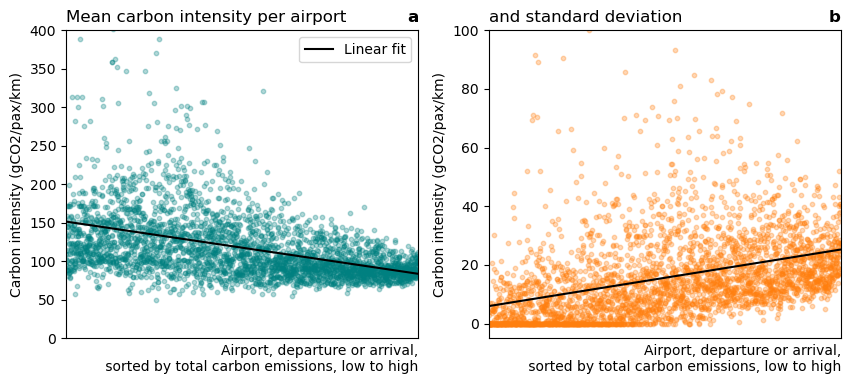

In [117]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

ax1.scatter(range(len(airports)), mean_intensity, 10, "teal", alpha=0.3)
ax2.scatter(range(len(airports)), np.sqrt(var_intensity), 10, "C1", alpha=0.3)

i = np.array([0, len(airports)])
mean_fit = f(i, *popt_mean)
var_fit = f(i, *popt_var)

ax1.plot(i, mean_fit, "k", label="Linear fit")
ax2.plot(i, var_fit, "k")

ax1.set_xlim(0, len(airports))
ax1.set_ylim(0, 400)
ax1.set_xticks([])
ax1.set_xlabel("Airport, departure or arrival,\n sorted by total carbon emissions, low to high", loc="right")
ax1.set_ylabel("Carbon intensity (gCO2/pax/km)")
ax1.set_title("Mean carbon intensity per airport", loc="left")
ax1.set_title("a", loc="right", fontweight="bold")
ax1.legend(loc="upper right")

ax2.set_ylim(-5, 100)
ax2.set_xlabel("Airport, departure or arrival,\n sorted by total carbon emissions, low to high", loc="right")
ax2.set_ylabel("Carbon intensity (gCO2/pax/km)")
ax2.set_title("and standard deviation", loc="left")
ax2.set_title("b", loc="right", fontweight="bold")

plt.show()

Fig ?: Carbon intensity per airport, departure or arrival. (a) Mean and (b) standard deviation of carbon intensities across all arriving or departing flights. Both mean and standard deviation are weighted by the respective carbon emissions of that flight. Airports are sorted by their respective total carbon emissions (half of all departures and arrivals), low to high. Linear least-square fits are a applied.